# About the Dataset and Problem Statement

- A real online retail transaction data set of two years.
- This dataset contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

## Importing required libraries

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import calendar

## Loading data

In [50]:
retail_raw = pd.read_csv("data/online_retail.csv")
retail = retail_raw.copy()
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Initial Data Inspection
- Understand the structure and quality of the dataset.


### Data Shape

In [51]:
retail.shape

(1067371, 8)

### Data types and memory usage

In [52]:
retail.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 345.1 MB


### Missing values

In [53]:
retail.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

### Duplicates

In [54]:
retail.duplicated().sum()

34335

## Data cleaning and preprocessing
- Identifing and handling missing values.
- Performing basic preprocessing for both numerical and categorical attributes.
- Handling duplicates.

In [55]:
retail = retail.drop_duplicates()

Invoices starting with 'C' represent cancelled orders and were removed form the dataset.

In [56]:
retail = retail[~retail['Invoice'].astype(str).str.startswith('C')].copy()

Rows with negative quantity or non-positive price were removed as they don't represent real sales or returns.

In [57]:
retail = retail[(retail['Quantity'] > 0) & (retail['Price'] > 0)].copy()

Changing data to appropriate data types and making some visual corrects.

In [58]:
retail['Description'] = retail['Description'].str.strip().str.lower()
retail['Quantity'] = retail['Quantity'].astype('Int32')
retail['Customer ID'] = retail['Customer ID'].astype('Int64')
retail['Country'] = retail['Country'].astype('category')
retail['Total'] = retail['Quantity'] * retail['Price']
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail = retail.rename(columns = {"Customer ID":"CustomerID"})

## Understanding missing Customer IDs

For sales analysis, I decided to keep rows with missing values in the 'Customer ID' column. Removing these rows would result in losing about 25% of transactions and could distort product popularity, total sales and seasonality patterns.
For customer analysis, rows with missing values in 'Customer ID' column were removed, as it is impossible to attribute these transactions to specific customers.

## Handling missing values

In [59]:
retail['Description'] = retail['Description'].fillna('Unknown')

In [60]:
# For customer analysis:
retail_customers = retail.dropna(subset=['CustomerID']).copy()
#For sales analysis:
retail_all = retail.copy()

## Clean Data

After removing duplicates, cancelled invoices and unncecesary data, the dataset contain 1010539 rows.

In [61]:
retail_all.shape

(1007913, 9)

Data types were optimized during cleaning (categorical conversion and integer downcasting),
reducing memory usage from ~345 MB to ~223 MB.

In [62]:
retail_all.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1007913 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1007913 non-null  object        
 1   StockCode    1007913 non-null  object        
 2   Description  1007913 non-null  object        
 3   Quantity     1007913 non-null  Int32         
 4   InvoiceDate  1007913 non-null  datetime64[ns]
 5   Price        1007913 non-null  float64       
 6   CustomerID   779425 non-null   Int64         
 7   Country      1007913 non-null  category      
 8   Total        1007913 non-null  Float64       
dtypes: Float64(1), Int32(1), Int64(1), category(1), datetime64[ns](1), float64(1), object(3)
memory usage: 223.6 MB


## Connecting with SQL

In [63]:
import sqlite3
conn = sqlite3.connect('retail.sqlite')

In [64]:
retail_all.to_sql(
    "transactions",
    conn,
    if_exists="replace",
    index=False
)
retail_customers.to_sql(
    "customer_transactions",
    conn,
    if_exists='replace',
    index=False
)

779425

## Overall statistics

In [65]:
retail_all[['Quantity','Price','Total']].describe()

,Quantity,Price,Total
count,1007913.0,1.007913e+06,1007913.0
mean,11.117178,4.074252e+00,20.315504
std,128.470025,5.043045e+01,205.715828
min,1.0,1.000000e-03,0.001
25%,1.0,1.250000e+00,4.13
50%,4.0,2.100000e+00,10.08
75%,12.0,4.130000e+00,17.7
max,80995.0,2.511109e+04,168469.6


### Key insights:
- Sales quantities and order values show strong right-skewness.
- A small number of very large transactions significantly impact the mean.
-Median values better represent a typical transaction.
- The dataset includes large wholesale-style purchases.

### Most expensive order

In [66]:
most_expensive_query = """
SELECT 
    Invoice,
    SUM(Total) AS order_value
FROM transactions
GROUP BY Invoice
ORDER BY order_value DESC
LIMIT 1
"""
most_expensive_order = pd.read_sql(most_expensive_query, conn)
most_expensive_order

,Invoice,order_value
0,581483,168469.6


### Average order value

In [67]:
average_order_query = """
SELECT 
    AVG(order_value) 
    FROM (
        SELECT Invoice,
        AVG(Total) as order_value
        FROM transactions
        GROUP BY Invoice
) 
"""
average_order = pd.read_sql(average_order_query, conn)
average_order

,AVG(order_value)
0,61.536652


# Country Analysis

## Top 10 Countries by number of orders

In [68]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["figure.dpi"] = 120

In [69]:
top_countries_query = """
SELECT
    Country,
    COUNT(DISTINCT Invoice) AS total_orders
FROM transactions
GROUP BY Country
ORDER BY total_orders DESC
LIMIT 10
"""
top_countries = pd.read_sql(top_countries_query, conn)

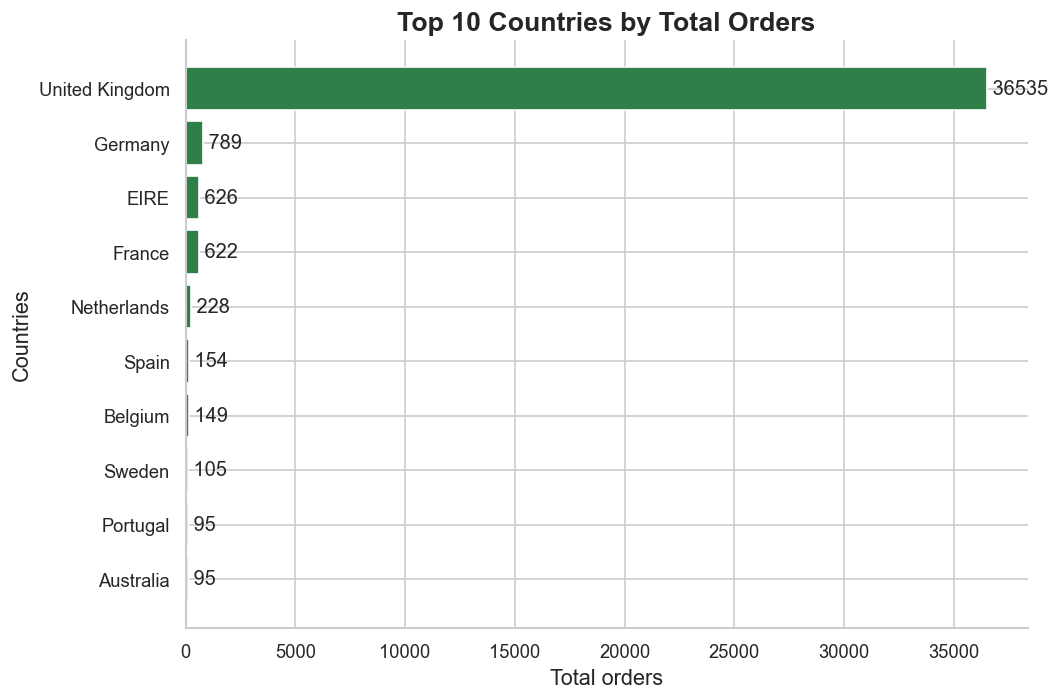

In [70]:
fig, ax = plt.subplots()

ax.barh(top_countries['Country'],
        top_countries['total_orders'],
        color = "#2e8048")

for i, v in enumerate(top_countries['total_orders']):
    ax.text(v, i, f" {v}", va='center')
    
ax.invert_yaxis()
ax.set_title("Top 10 Countries by Total Orders", 
             fontsize = 16, fontweight = 'bold')
ax.set_xlabel("Total orders", fontsize = 13)
ax.set_ylabel("Countries", fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

### Conclusions
- The United Kingdom clearly dominates in terms of total number of orders. 
- The distribution is highly skewed, with one country generating the vast majority of transactions.
- The remaining countries contribute relatively small volumes compared to the UK.
- As the company is based in the UK, it may indicate a strong focus on the domestic market rather than international expansion.

For second analysis the United Kingdom was excluded to avoid scale distortion and to better compare the remaining countries.

In [71]:
top_countries_no_uk = top_countries.loc[top_countries['Country'] != 'United Kingdom']

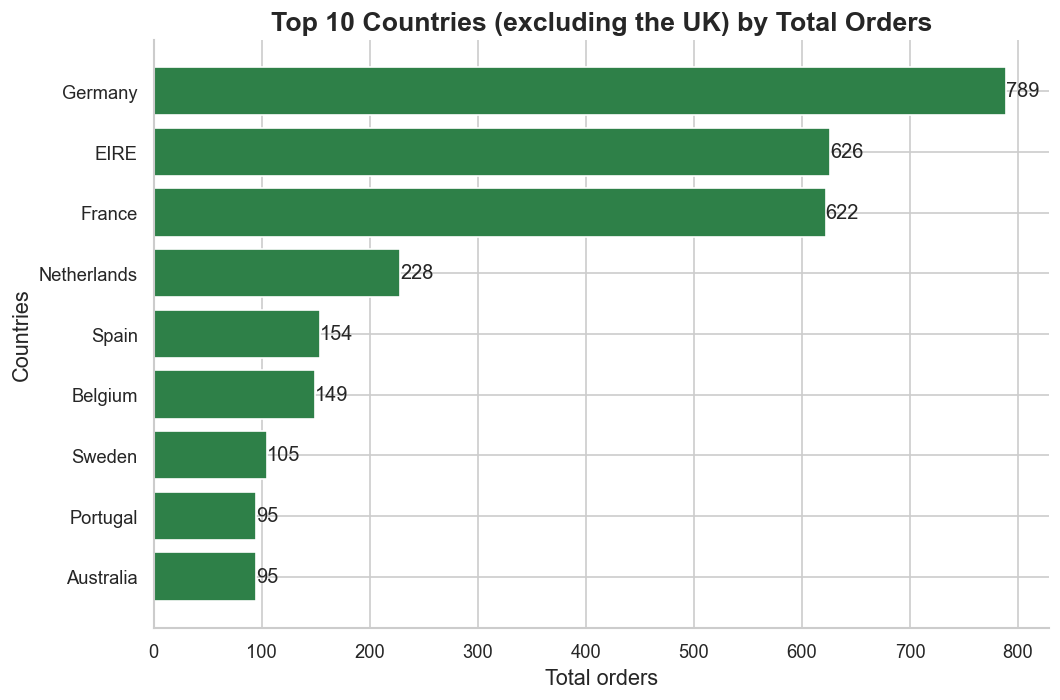

In [72]:
fig, ax = plt.subplots()

ax.barh(top_countries_no_uk['Country'],
        top_countries_no_uk['total_orders'],
        color = "#2e8048")

for i,v in enumerate(top_countries_no_uk['total_orders']):
    ax.text(v, i, f"{v}", va = 'center')

ax.invert_yaxis()  
ax.set_title("Top 10 Countries (excluding the UK) by Total Orders", 
             fontsize = 16, fontweight = 'bold')
ax.set_xlabel("Total orders", fontsize = 13)
ax.set_ylabel("Countries", fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

## Top 10 countries by revenue

In [73]:
top_countries_revenue_query = """
SELECT
    Country,
    SUM(Total) AS total_revenue
FROM transactions
GROUP BY Country
ORDER BY total_revenue DESC
LIMIT 10
"""
top_countries_by_revenue = pd.read_sql(top_countries_revenue_query, conn)

Similarly to previous analysis, UK dominates in term of revenue so visualization was performed without it.

In [74]:
top_countries_revenue_no_uk = top_countries_by_revenue.loc[top_countries_by_revenue['Country'] != 'United Kingdom']

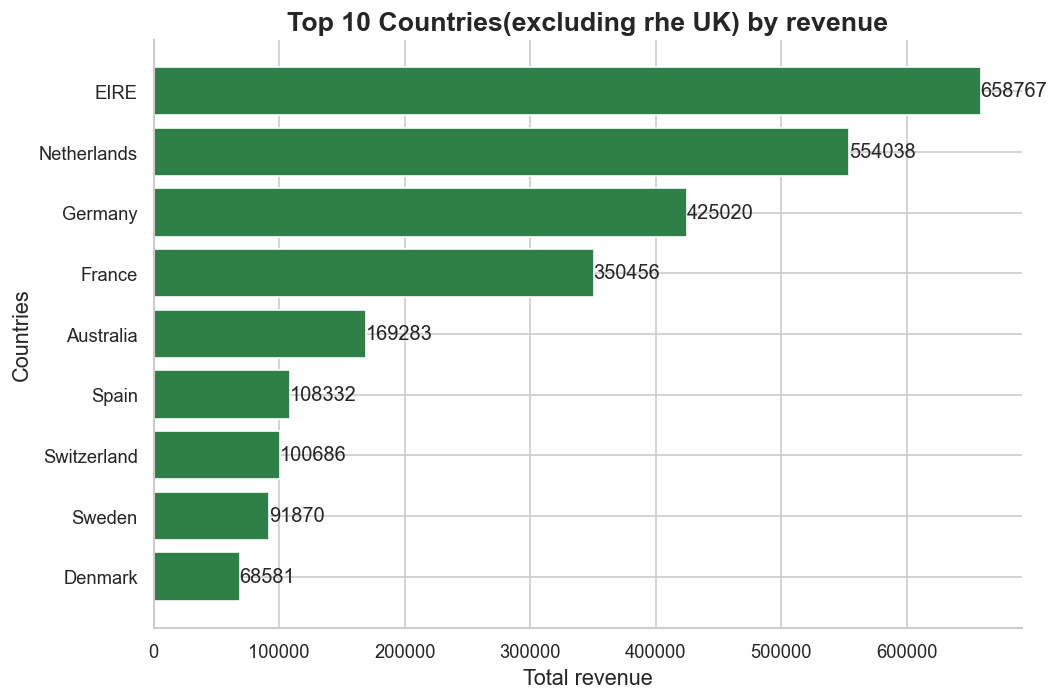

In [75]:
fig, ax = plt.subplots()

ax.barh(top_countries_revenue_no_uk['Country'],
        top_countries_revenue_no_uk['total_revenue'],
        color = "#2e8048")

for i,v in enumerate(top_countries_revenue_no_uk['total_revenue']):
    ax.text(v, i, f"{v:.0f}", va = 'center')
    
ax.invert_yaxis()  
ax.set_title("Top 10 Countries(excluding rhe UK) by revenue", 
             fontsize = 16, fontweight = 'bold')
ax.set_xlabel("Total revenue", fontsize = 13)
ax.set_ylabel("Countries", fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

### Conclusions
- After excluding the UK, the distribution becomes significantly more balanced.
- Germany, EIRE, France and the Netherlands generate both the highest number of orders and the highest revenue among the remaining countries.
- The differences between the other countries are relatively moderate, suggesting a comparable level of demand.
- These markets may represent potential opportunities for further expansion and revenue growth.
- Overall, the analysis highlights the importance of geographical diversification to reduce reliance on one dominant market.

# Products analysis

## Top 10 products

In [76]:
top_products_query = """
SELECT
    Description, 
    SUM(Quantity) AS total_sold,
    ROUND(SUM(Total) * 1.0 / SUM(Quantity),2) As avg_price
FROM transactions
WHERE Description != 'Unknown'
GROUP BY
Description
ORDER BY total_sold DESC
LIMIT 10
"""
top_products = pd.read_sql(top_products_query, conn)

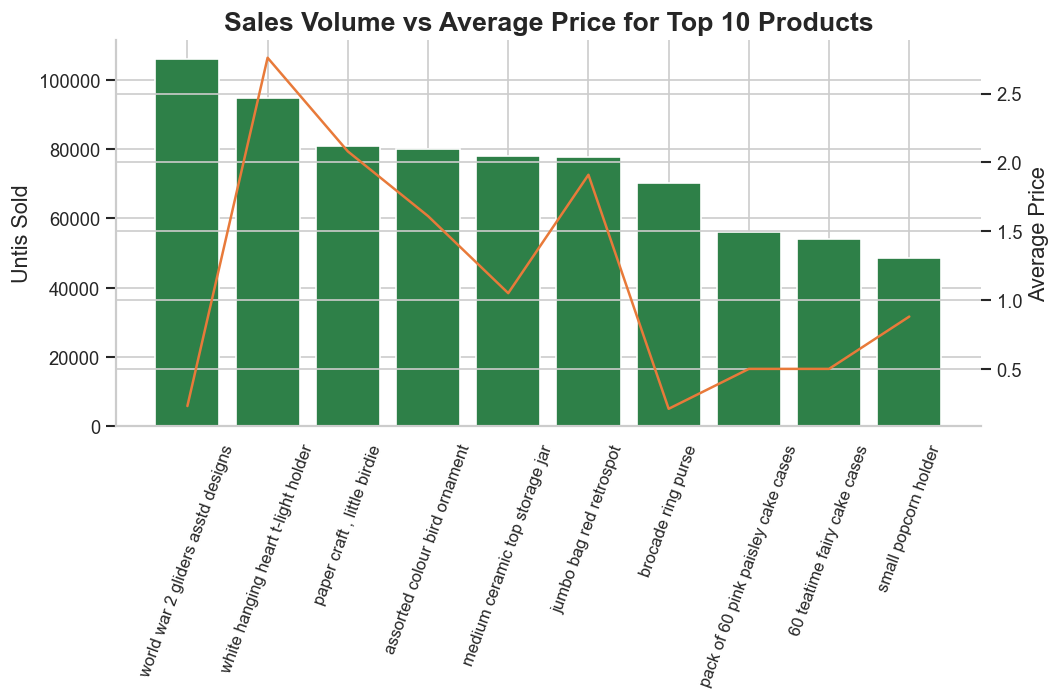

In [77]:
fig, ax = plt.subplots()

ax.bar(top_products['Description'], top_products['total_sold'], color = "#2e8048")

ax1 = ax.twinx()

ax1.plot(top_products['Description'], top_products["avg_price"], color = "#e87a3a")

ax.tick_params(axis = 'x', rotation =70, labelsize= 10)
ax.set_title("Sales Volume vs Average Price for Top 10 Products", 
             fontsize = 16, fontweight = 'bold')
ax.set_ylabel("Untis Sold", fontsize = 13)
ax1.set_ylabel("Average Price", fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

### Conclusions
- The chart suggests a potential relationship between price and demand.
- Products with lover average prices tend to habe higher sales volumes.
- However, a proper correlation analysis would be required to confirm this relationship.

## Price vs Demand Relationship

In [78]:
all_products_query = """
SELECT
    Description, 
    SUM(Quantity) AS total_sold,
    ROUND(SUM(Total) * 1.0 / SUM(Quantity),2) As avg_price
FROM transactions
WHERE Description != 'Unknown'
GROUP BY
Description
"""
all_products = pd.read_sql(all_products_query, conn)

In [79]:
pearson = all_products['avg_price'].corr(all_products['total_sold'])
spearman = all_products['avg_price'].corr(all_products['total_sold'], method='spearman')

In [80]:
print(f"Spearman correlation coefficient: {spearman:.2f}")

Spearman correlation coefficient: -0.39


In [81]:
print(f"Pearson correlation coefficient: {pearson:.2f}")

Pearson correlation coefficient: -0.01


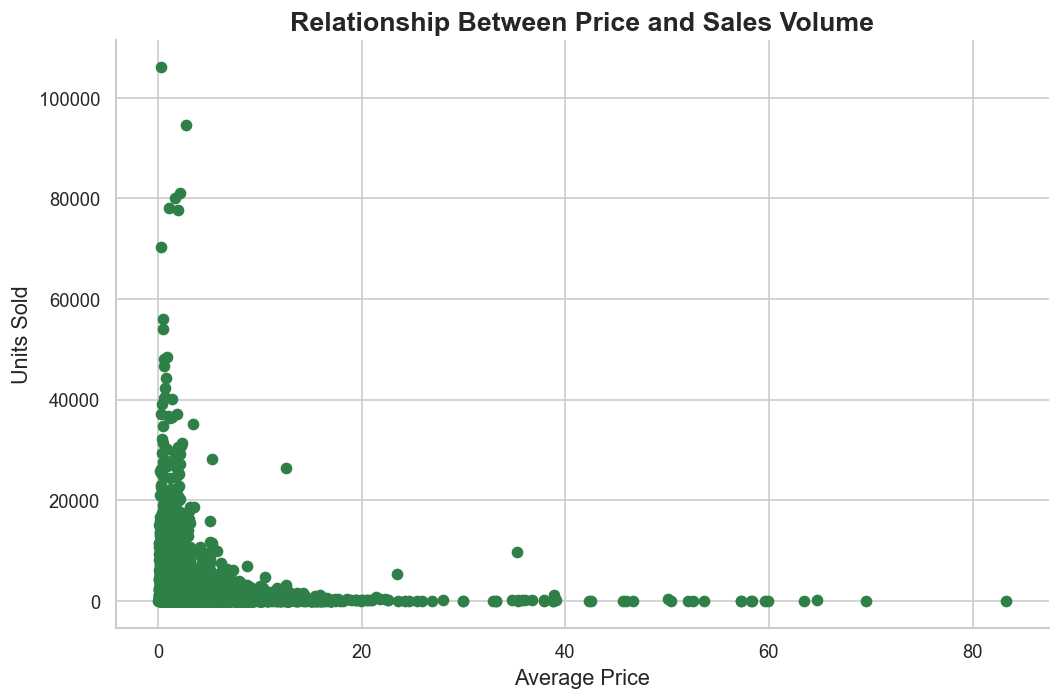

In [82]:
fig, ax = plt.subplots()

all_products = all_products[all_products['avg_price'] < 100]

plt.scatter(all_products['avg_price'], all_products['total_sold'], color = "#2e8048" )
plt.title("Relationship Between Price and Sales Volume", 
          fontsize = 16, fontweight = 'bold')
plt.xlabel("Average Price", fontsize = 13)
plt.ylabel("Units Sold",  fontsize = 13)
#plt.xscale('log')

sns.despine()
plt.tight_layout()
plt.show()

## Methodology
Extreme price outliers were removed for visualization clarity.

### Conclusions
- Although no significant linear relationship was found (r ≈ 0.01), the moderate negative Spearman correlation (r ≈ -0.39) suggests that higher prices are generally associated with lower sales volumes.
- This indicates that price may influence demand in a non-linear manner.

# Time base analysis

## Monthly analysis

In [83]:
retail_all['months'] = retail_all['InvoiceDate'].dt.month
best_month = (
    retail_all.groupby('months')['Total'].sum()
)

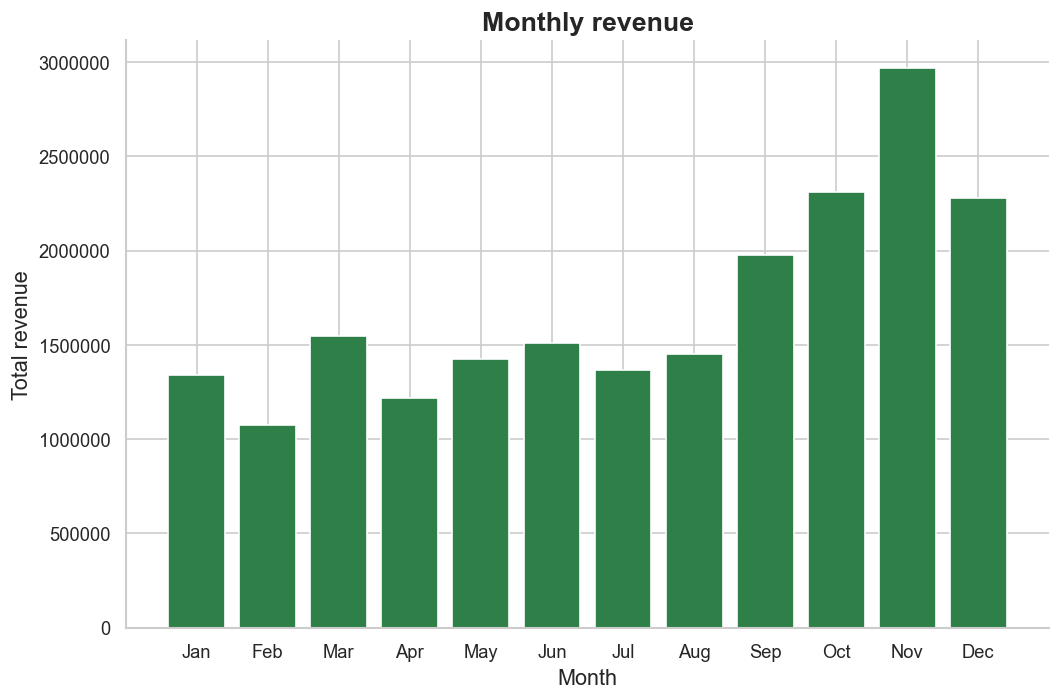

In [84]:
fig, ax = plt.subplots()

ax.bar(best_month.index,
       best_month.values, 
       color = '#2e8048')

ax.set_xticks(best_month.index)
ax.set_xticklabels([calendar.month_abbr[i] for i in best_month.index])

ax.ticklabel_format(style='plain', axis='y')
ax.set_title('Monthly revenue', 
             fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Total revenue', fontsize = 13)
ax.set_xlabel('Month', fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

## Sales by months

In [85]:
sales_by_month = retail_all.set_index("InvoiceDate").loc[:,["Total"]].resample("ME").sum()

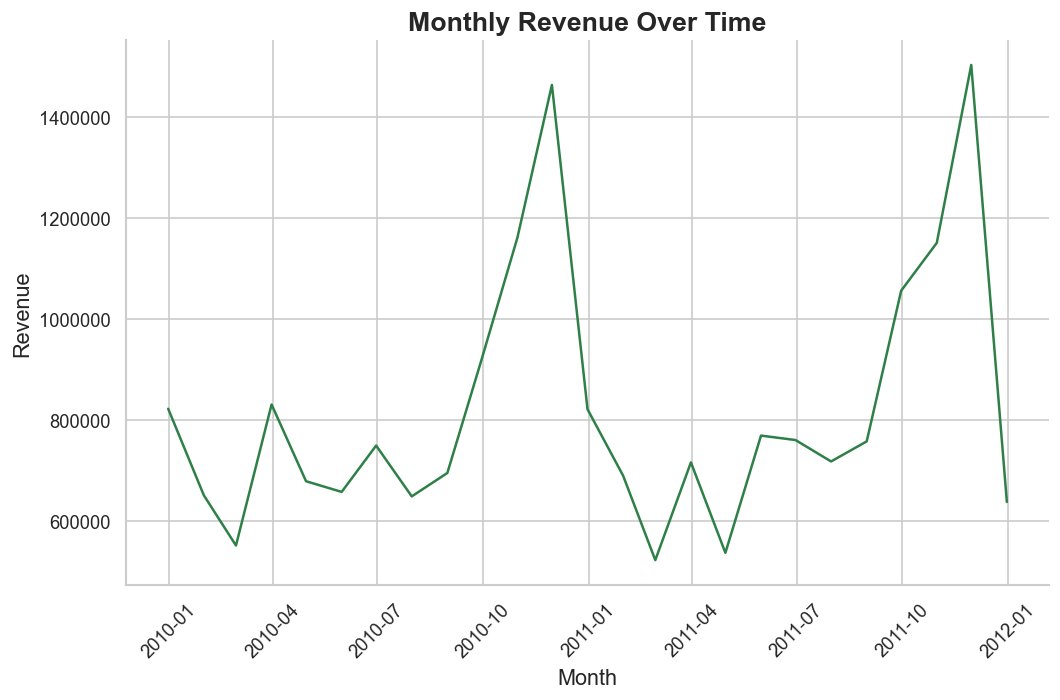

In [86]:
fig,ax = plt.subplots()

ax.plot(sales_by_month, 
        color ='#2e8048')
ax.tick_params(axis='x', rotation=45)
ax.ticklabel_format(style='plain', axis='y')   
ax.set_title("Monthly Revenue Over Time", 
             fontsize = 16, fontweight = 'bold')
ax.set_xlabel("Month", fontsize = 13)
ax.set_ylabel("Revenue", fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

## Monthly sales: 2010 vs 2011

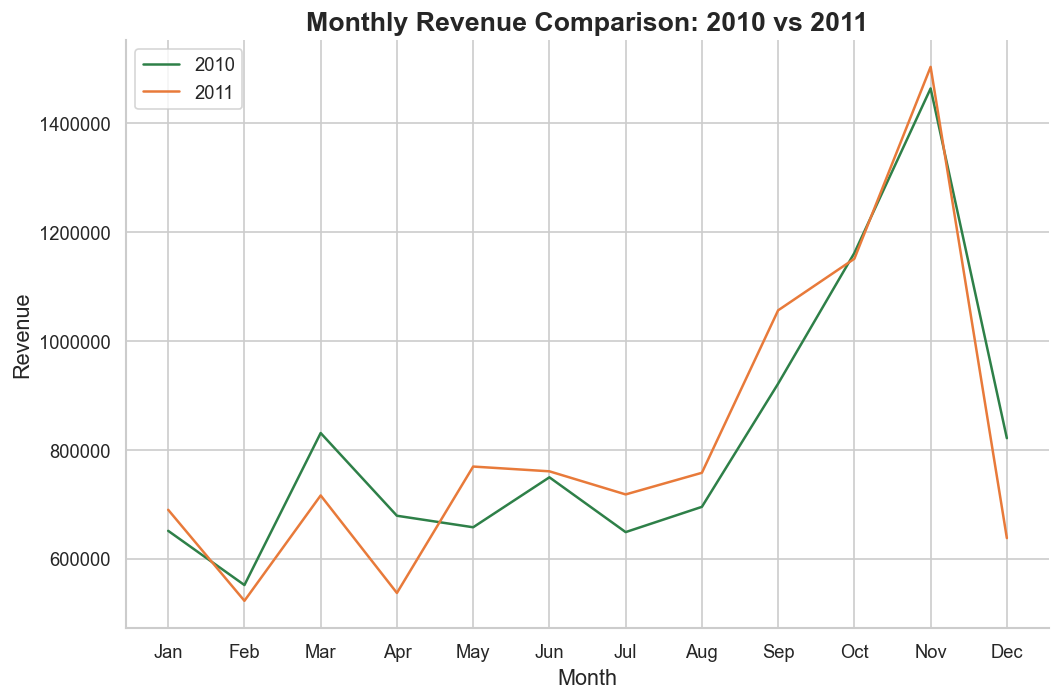

In [87]:
sales_2010 = sales_by_month.loc['2010', 'Total']
sales_2011 = sales_by_month.loc['2011', 'Total']

fig, ax = plt.subplots()

ax.plot(sales_2010.index.month, sales_2010,
        label='2010', color = '#2e8048')

ax.plot(sales_2011.index.month, sales_2011,
        label='2011', color = "#e87a3a")

ax.set_xticks(range(1, 13))
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
ax.set_title("Monthly Revenue Comparison: 2010 vs 2011",
             fontsize=16, fontweight='bold')
ax.set_xlabel("Month", fontsize=13)
ax.set_ylabel("Revenue", fontsize=13)
ax.legend()
ax.ticklabel_format(style='plain', axis='y')

sns.despine()
plt.tight_layout()
plt.show()

### Conclusions
- November appears to be the strongest month in terms of revenue.
- October, December and September also show relatively high sales levels.
- This pattern suggests increased purchasing activity in the pre-holiday and holiday season.
- Lower sales during spring and summer months may indicate an opportunity to introduce promotional campaigns to stimulate demand.
- Sales in 2011 appear to be higher than in 2010 during the second half of the year, indicating possible business growth.

## Year-over-Year growth

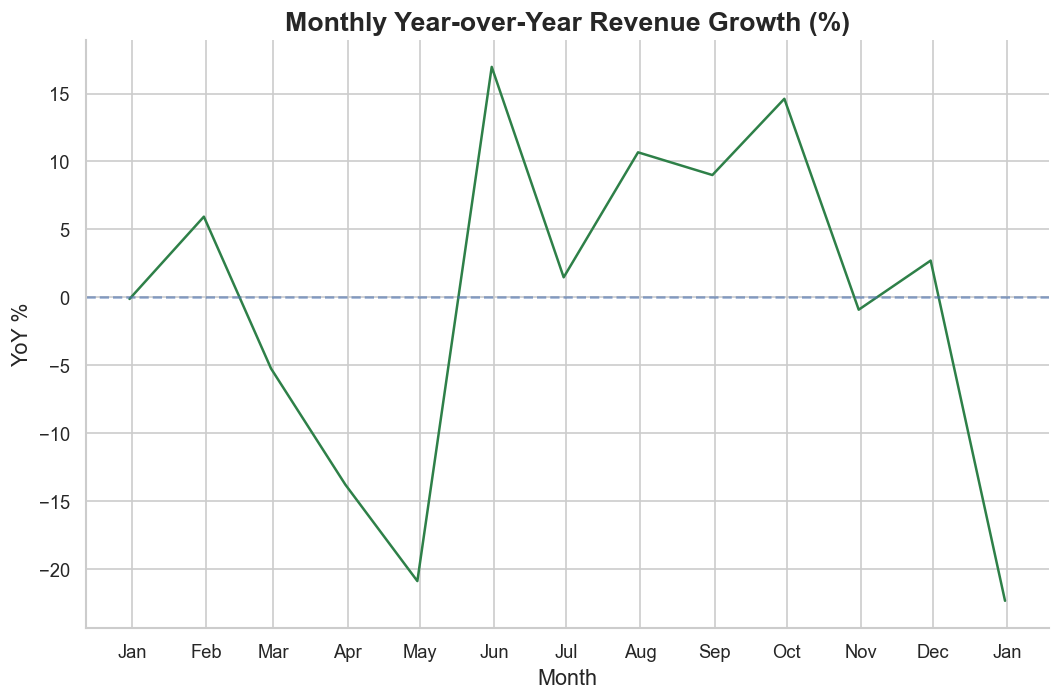

In [88]:
YoY = (sales_by_month/sales_by_month.shift(12) - 1) * 100

fig, ax = plt.subplots()

ax.plot(YoY.index, YoY,
       color = "#2e8048" )
ax.set_title("Monthly Year-over-Year Revenue Growth (%)", fontsize = 16, fontweight = 'bold')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.axhline(0, linestyle='--', alpha=0.6)
ax.set_xlabel("Month", fontsize = 13)
ax.set_ylabel("YoY %", fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

### Conclusions
- Year-over-Year growth shows significant volatility throughout the year.
- The strongest positive growth is observed in June and October, while May and January show notable declines.
- Growth appears to accelerate in the second half of the year, supporting the earlier observation of stronger Q4 performance
- The sharp decline in the final month may be influenced by incomplete data for that period.

## Which day of week is the best for sales?

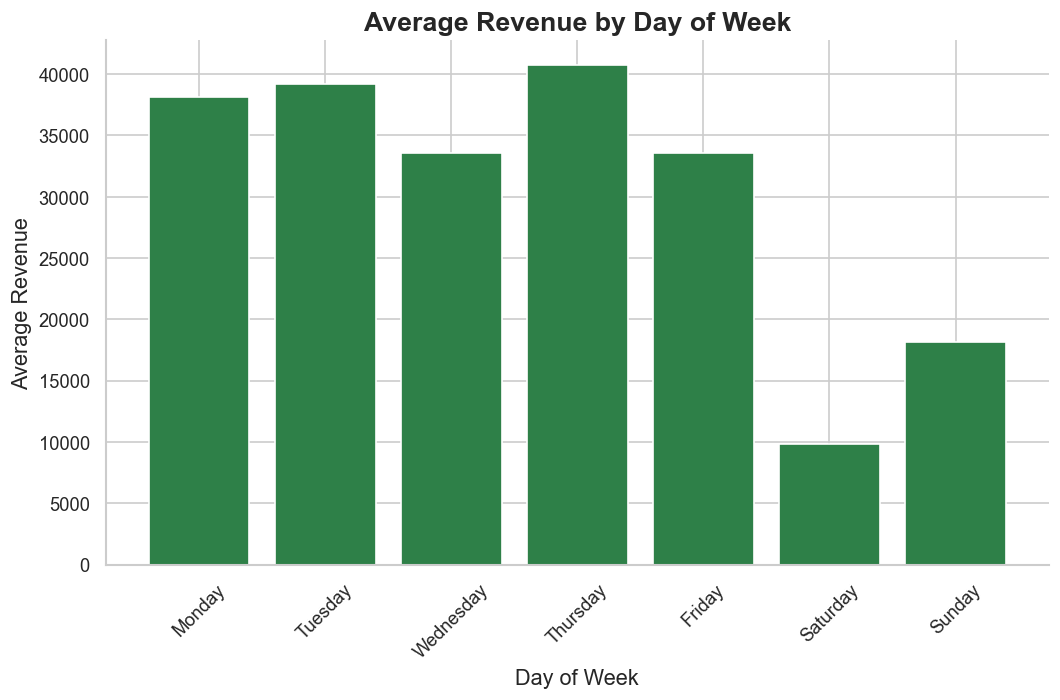

In [89]:
fig, ax = plt.subplots()

daily_sales = (
    retail_all
    .groupby(retail_all["InvoiceDate"].dt.date)
    .agg({'Total':'sum'})
        )

sales_by_day_of_week = (
    daily_sales
    .groupby(pd.to_datetime(daily_sales.index).dayofweek)
    .mean()
)

ax.bar(sales_by_day_of_week.index, 
       sales_by_day_of_week['Total'],
      color = "#2e8048" )

ax.set_xticks(sales_by_day_of_week.index)
ax.set_xticklabels(
    ["Monday","Tuesday","Wednesday",
     "Thursday","Friday","Saturday","Sunday"])
ax.set_title('Average Revenue by Day of Week', 
             fontsize = 16, fontweight = 'bold')
ax.ticklabel_format(axis = 'y', style = 'plain')
ax.tick_params(axis = "x", rotation = 45)
ax.set_xlabel('Day of Week', fontsize = 13)
ax.set_ylabel('Average Revenue', fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

### Distribution of available days

In [90]:
pd.to_datetime(daily_sales.index).dayofweek.value_counts().sort_index()

InvoiceDate
0     94
1    104
2    104
3    103
4     99
5      1
6     99
Name: count, dtype: int64

### Methodological note
To avoid bias from unequal number of observations per weekday, average daily revenue was calculated instead of total revenue.

### Conclusions
- Average daily sales are relatively consistent across weekdays, with Thursday showing the strongest performance.
- Sunday sales are noticeably lower compared to weekdays.
- However, it is important to note that only one Saturday is present in the dataset, making Saturday results statistically unreliable.

## Number of orders by hours

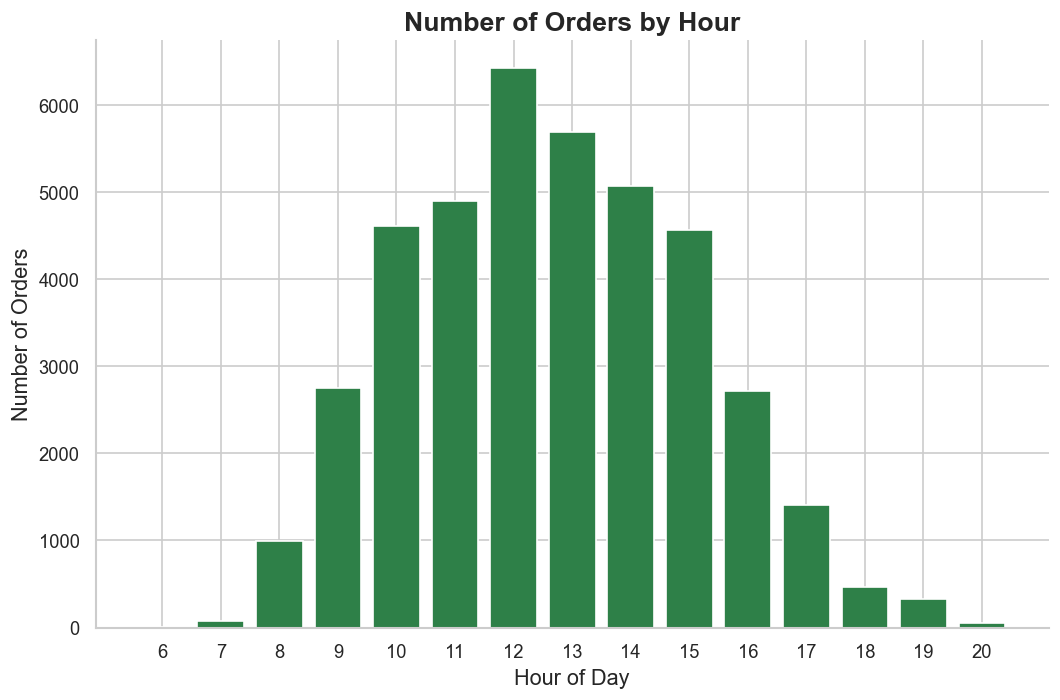

In [97]:
orders_by_hours = retail_all.groupby(retail_all['InvoiceDate'].dt.hour)['Invoice'].nunique()

fig, ax = plt.subplots()
ax.bar(orders_by_hours.index,
      orders_by_hours.values, 
       color = "#2e8048")
ax.set_title('Number of Orders by Hour', 
             fontsize = 16, fontweight = 'bold')
ax.set_xticks(orders_by_hours.index)
ax.set_xlabel('Hour of Day', fontsize = 13)
ax.set_ylabel('Number of Orders', fontsize = 13)

sns.despine()
plt.tight_layout()
plt.show()

### Conlusions
- Order activity is concentrated between 9 AM and 13 PM.
- The peak hour occurs around 12 PM, indicating the highest customer activity at midday.
- Very few orders are placed early in the morning or in the evening.
- The distribution suggests standard business-hour purchasing behavior.
- These insights may support staffing optimization and targeted marketing campaigns during peak hours.

# Customer analysis

## Top customer by revenue

In [92]:
top_customers_query = """
SELECT
    CustomerID,
    SUM(Total) AS revenue,
    ROUND(SUM(Total) * 100.0/
    (SELECT SUM(Total) FROM customer_transactions),2)AS percentage_contribution
FROM 
customer_transactions
GROUP BY
CustomerID
ORDER BY revenue DESC
LIMIT 10
"""
top_customers = pd.read_sql(top_customers_query, conn)

In [93]:
top_customers['cumulative_pct'] = top_customers["percentage_contribution"].cumsum()

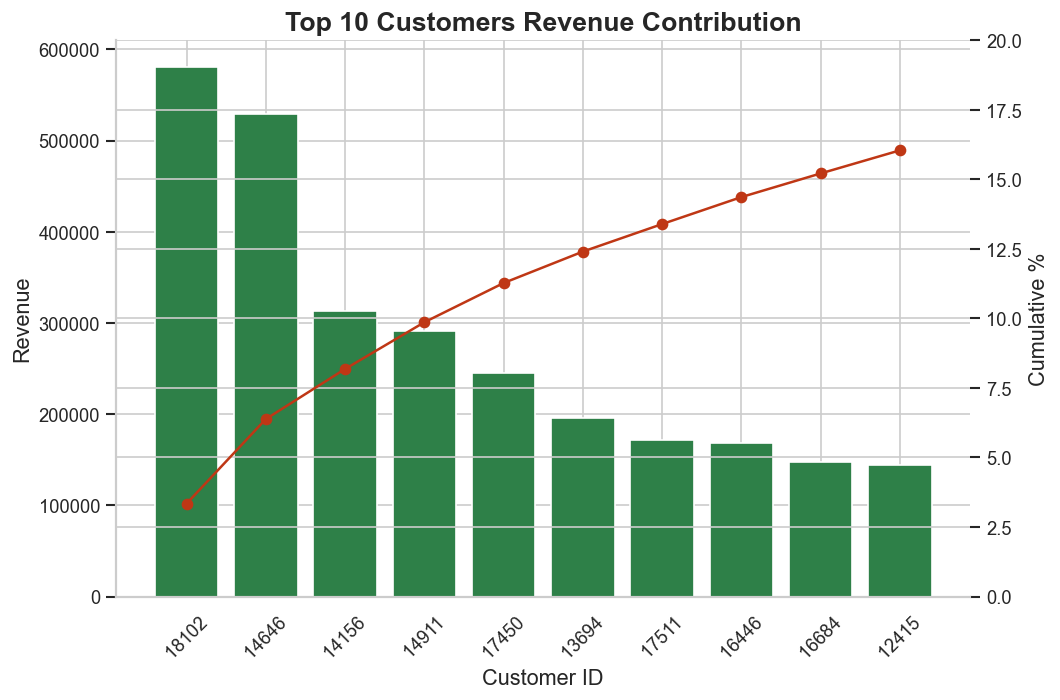

In [94]:
fig, ax1 = plt.subplots()

x_labels = top_customers["CustomerID"].astype(str)
ax1.bar(x_labels,
       top_customers["revenue"],
       color = "#2e8048")
ax1.set_ylabel("Revenue", fontsize = 13)
ax1.set_xlabel("Customer ID", fontsize = 13)
ax1.set_title("Top 10 Customers Revenue Contribution", 
              fontsize = 16,fontweight="bold")
ax1.tick_params(axis="x", rotation=45)

ax2 = ax1.twinx()
ax2.plot(x_labels,
         top_customers["cumulative_pct"],
         marker = "o",
         color ="#bf3715")

ax2.set_ylabel("Cumulative %", fontsize = 13)
ax2.set_ylim(0, 20)

sns.despine()
plt.tight_layout()
plt.show()

### Conclusions

- The top 10 customers account for approximately 15% of total revenue.
- Revenue is not highly concentrated among a small group of clients.
- The business appears to rely on a broad customer base rather than a few dominant buyers.
- This suggests lower dependency risk on individual customers compared to businesses with highly concentrated revenue structures.

## Distribution of orders per customer

In [95]:
orders_by_customer_query= """
SELECT
    COUNT(DISTINCT Invoice) as total_orders
FROM customer_transactions
GROUP BY CustomerID
"""
orders_by_customer = pd.read_sql(orders_by_customer_query, conn)

order_counts = (
    orders_by_customer["total_orders"]
    .value_counts()
    .sort_index()
)

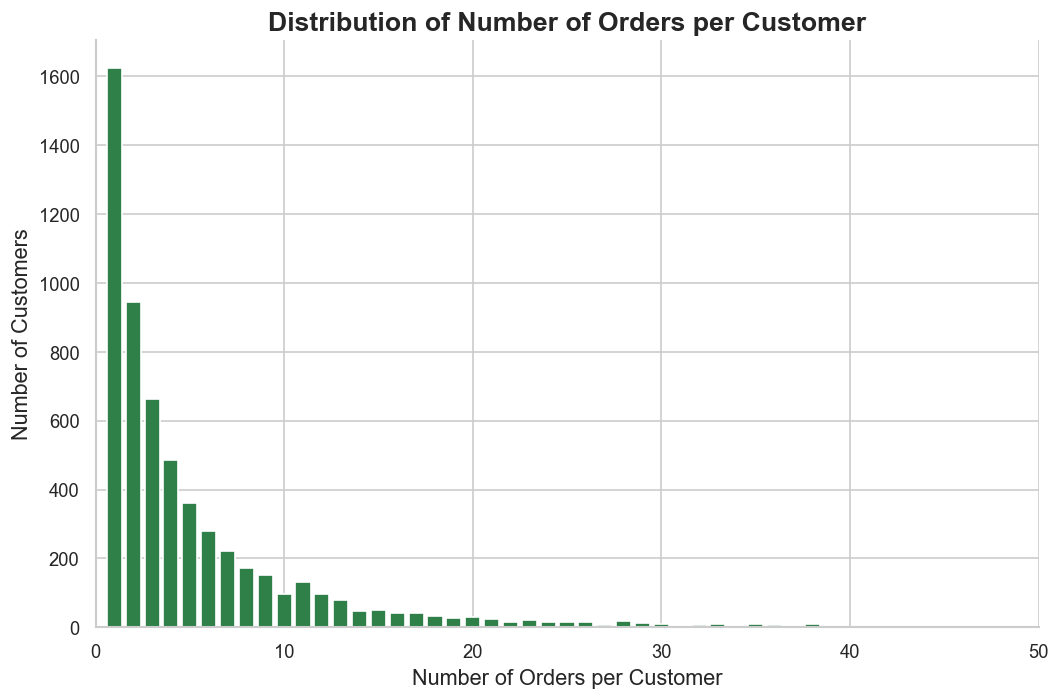

In [96]:
fig, ax = plt.subplots()

ax.bar(order_counts.index, order_counts.values, color = "#2e8048")

ax.set_xlim(0, 50)
#ax.set_xticks(range(0, 21))
ax.set_xlabel("Number of Orders per Customer", fontsize= 13)
ax.set_ylabel("Number of Customers", fontsize = 13)
ax.set_title("Distribution of Number of Orders per Customer", 
             fontsize = 16, fontweight="bold")

sns.despine()
plt.tight_layout()
plt.show()

## Methodology
For better visualization clarity, the chart focuses on customers with up to 50 orders. A small number of extreme outliers place significantly more orders.

### Conslusions
- The majority of customers place only one order, indicating a high proportion of one-time buyers.
- The number of customers decreases significantly as the number of orders increases.
- Only a small percentage of customers place more than 10 orders, suggesting that highly loyal customers represent a small segment.
- The distribution is right-skewed, which is typical for e-commerce businesses.
- This pattern highlights the importance of customer retention strategies to increase repeat purchases.

# Final Business Conclusions
- The company primarily focuses on the domestic market, with the UK generating the vast majority of transactions and revenue.
- Price appears to influence demand in a non-linear manner.
- Revenue demonstrated strong seasonality, with a significant peak in Q4, particularly in November and noticeably lower sales during spring and summer months.
- The distribution of orders suggests standard business-hour purchasing behavior, with peak activity around 12 PM.
- Revenue is not highly concentrated among a small group of customers, the business appears to rely on broad customer base.
- The majority of customers place only one or two orders.


# Potential Business Recommendations
- Develop a structured international expansion strategy to increase revenue outside the UK market.
- Prepare inventory planning and optimize staffing levels ahead of Q4 season to accomodate increased holiday demand.
- Implement targeted  marketing and promotional campaigns during low-season months (spring and summer) to stabilize revenue throughout the year.
- Adjust staffing allocation to better support peak purchasing hours.
- Introduce customer loyalty programs to increase repeat purchase rates.